In [5]:
#Import everything
import pandas as pd
# import cartopy
# import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import csv
import powerlaw
import os
# import proplot as pplt
from datetime import datetime

In [145]:
pd.read_csv('/Volumes/Extreme SSD/Documents/Notebooks/FSD/floe_props/ift_floe_properties_2003.csv').columns

Index(['Unnamed: 0', 'datetime', 'satellite', 'floe_id', 'label', 'longitude',
       'latitude', 'x_stere', 'y_stere', 'col_pixel', 'row_pixel', 'area',
       'perimeter', 'solidity', 'orientation', 'circularity',
       'axis_major_length', 'axis_minor_length', 'bbox_min_row',
       'bbox_min_col', 'bbox_max_row', 'bbox_max_col', 'area_matlab',
       'perimeter_matlab', 'solidity_matlab', 'orientation_matlab',
       'nsidc_sic', 'theta_aqua', 'theta_terra', 'tc_channel0', 'tc_channel1',
       'tc_channel2', 'fc_channel0', 'fc_channel1', 'fc_channel2',
       'init_classification', 'lr_probability', 'lr_classification',
       'final_classification', 'edge_dist_km', 'coast_dist_km'],
      dtype='object')

In [146]:
temp = []
for year in range(2003, 2021):
    temp.append(pd.read_csv('/Volumes/Extreme SSD/Documents/Notebooks/FSD/floe_props/ift_floe_properties_{y}.csv'.format(y=year),
                            parse_dates=True))
df = pd.concat(temp)
df['datetime'] = pd.to_datetime(df['datetime'].values)
df = df.loc[(df.datetime.dt.dayofyear >= 91) & (df.datetime.dt.dayofyear <= 258)]

In [147]:
df['perim_km'] = df.perimeter*.25
df['area_km'] = df.area*.25*.25
df['area_adj_km'] = (np.sqrt(df.area) + 6)**2*.25*.25 # 6 pixel shift minimizes error against manual
df['doy'] = df.datetime.dt.dayofyear
df['year'] = df.datetime.dt.year

## compare SIC 

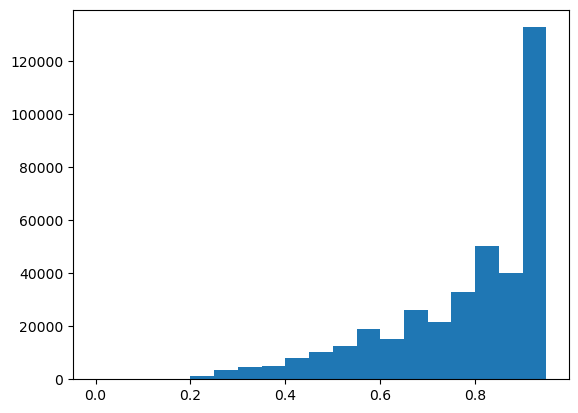

In [148]:
plt.hist(df.nsidc_sic,bins=np.arange(0,1,.05));

In [173]:
df_lt85=df[df.nsidc_sic<=.8]
df_gt85=df[df.nsidc_sic>.8]
cond1=r'SIC $\leq$ 80%'
cond2=r'SIC > 80'

In [174]:
count_range

doy,91,92,93,94,95,96,97,98,99,100,...,249,250,251,252,253,254,255,256,257,258
0.10,35.6,29.1,27.6,21.3,16.0,7.5,10.8,8.2,21.2,18.8,...,6.10,1.0,7.6,7.6,3.4,5.30,8.10,4.0,7.5,3.00
0.25,55.0,47.5,33.0,33.0,19.0,23.5,21.0,28.0,29.0,33.5,...,15.50,11.0,15.0,14.0,6.5,8.00,10.50,8.0,13.5,5.25
0.50,64.0,65.5,48.0,54.5,60.0,82.5,28.0,49.0,49.0,45.0,...,28.50,27.0,25.0,27.0,14.0,13.00,16.00,19.0,18.0,21.00
0.75,85.0,87.0,88.0,69.0,93.0,107.0,76.0,89.0,68.0,72.5,...,33.75,35.0,47.0,34.0,27.5,17.75,33.75,20.0,24.0,31.00
0.90,128.4,105.5,104.2,106.3,145.4,159.5,127.4,117.6,123.2,82.6,...,61.60,62.0,63.8,44.2,38.4,30.00,62.10,46.6,36.9,40.00


In [175]:
smoothed_count_range = count_range.T.rolling(15, center=True).mean()

In [176]:
smoothed_count_range.columns

Index([0.1, 0.25, 0.5, 0.75, 0.9], dtype='float64')

In [181]:
doys_lt=[]
doys_gt=[]
alphas_lt=[]
alphas_gt=[]

for d in np.arange(91,258):
    df_lt_temp=df_lt85[df_lt85.doy==d]
    df_gt_temp=df_gt85[df_gt85.doy==d]
    if len(df_lt_temp)>300:
        data=df_lt_temp.area_km
        fit = powerlaw.Fit(data, xmin=35)
        alphas_lt=np.append(alphas_lt,fit.power_law.alpha)
        doys_lt=np.append(doys_lt,d)
    if len(df_gt_temp)>300:
        data=df_gt_temp.area_km
        fit = powerlaw.Fit(data, xmin=35)
        alphas_gt=np.append(alphas_gt,fit.power_law.alpha)
        doys_gt=np.append(doys_gt,d)

/opt/miniconda3/envs/lif-env/lib/python3.12/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


In [182]:
doys_lt_s=[]
doys_gt_s=[]
alphas_lt_s=[]
alphas_gt_s=[]
sigs_gt=[]
sigs_lt=[]

for d in np.arange(91,258):
    df_lt_temp=df_lt85[(df_lt85.doy>(d-2))&(df_lt85.doy<(d+2))]
    df_gt_temp=df_gt85[(df_gt85.doy>(d-2))&(df_gt85.doy<(d+2))]
    if len(df_lt_temp)>300:
        data=df_lt_temp.area_km
        fit = powerlaw.Fit(data, xmin=35)
        alphas_lt_s=np.append(alphas_lt_s,fit.power_law.alpha)
        sigs_lt=np.append(sigs_lt,fit.power_law.sigma)
        doys_lt_s=np.append(doys_lt_s,d)
    if len(df_gt_temp)>300:
        data=df_gt_temp.area_km
        fit = powerlaw.Fit(data, xmin=35)
        alphas_gt_s=np.append(alphas_gt_s,fit.power_law.alpha)
        sigs_gt=np.append(sigs_gt,fit.power_law.sigma)
        doys_gt_s=np.append(doys_gt_s,d)

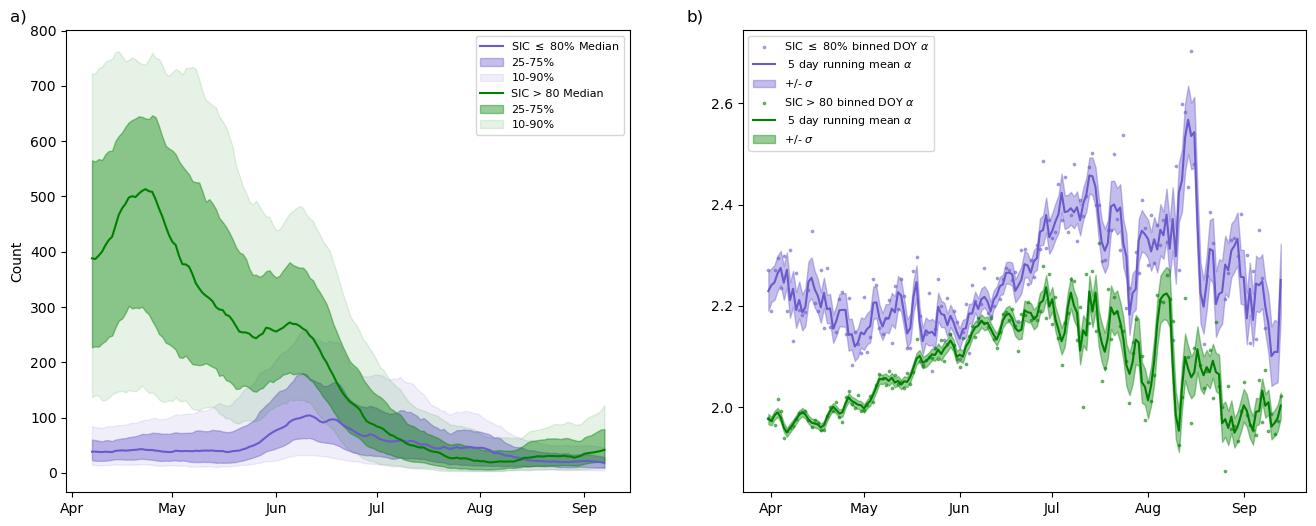

In [183]:
count_range_lt85 = df_lt85.groupby(['year', 'doy']).count().pivot_table(index='year', columns='doy', values='datetime').quantile([0.1, 0.25, 0.5, 0.75, 0.9], axis=0)
smoothed_count_range_lt85 = count_range_lt85.T.rolling(15, center=True).mean()

count_range_gt85 = df_gt85.groupby(['year', 'doy']).count().pivot_table(index='year', columns='doy', values='datetime').quantile([0.1, 0.25, 0.5, 0.75, 0.9], axis=0)
smoothed_count_range_gt85 = count_range_gt85.T.rolling(15, center=True).mean()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,6))

ax[0].plot(smoothed_count_range_lt85.index,smoothed_count_range_lt85[0.5],color='slateblue',label=cond1+r' Median')
ax[0].fill_between(smoothed_count_range_lt85.index,smoothed_count_range_lt85[0.25],smoothed_count_range_lt85[0.75],color= 'slateblue',alpha=0.4,label=r'25-75%')
ax[0].fill_between(smoothed_count_range_lt85.index,smoothed_count_range_lt85[0.1],smoothed_count_range_lt85[0.9],color='slateblue',alpha=0.1,label=r'10-90%')

ax[0].plot(smoothed_count_range_gt85.index,smoothed_count_range_gt85[0.5],color='green',label=cond2+' Median')
ax[0].fill_between(smoothed_count_range_gt85.index,smoothed_count_range_gt85[0.25],smoothed_count_range_gt85[0.75],color='green',alpha=0.4,label='25-75%')
ax[0].fill_between(smoothed_count_range_gt85.index,smoothed_count_range_gt85[0.1],smoothed_count_range_gt85[0.9],color='green',alpha=0.1,label='10-90%')


dr = pd.date_range('2020-04-01', '2020-09-01', freq='1MS')
ax[0].set_xticks(dr.dayofyear, [d.strftime('%b') for d in dr]);
ax[0].set_ylabel('Count')

ax[0].legend( fontsize=8)
ax[0].set_title('a)', loc='left', x=-.1)

ax[1].scatter(doys_lt,alphas_lt,color='slateblue',s=3,alpha=0.5,label=cond1+r' binned DOY $\alpha$' )
ax[1].plot(doys_lt_s,alphas_lt_s,color='slateblue',label= r' 5 day running mean $\alpha$')
ax[1].fill_between(doys_lt_s,alphas_lt_s-sigs_lt,alphas_lt_s+sigs_lt,color='slateblue',alpha=0.4,label=r'+/- $\sigma$')

ax[1].scatter(doys_gt,alphas_gt,color='green',s=3,alpha=0.5,label=cond2+r' binned DOY $\alpha$')
ax[1].plot(doys_gt_s,alphas_gt_s,color='green',label=r' 5 day running mean $\alpha$')
ax[1].fill_between(doys_gt_s,alphas_gt_s-sigs_gt,alphas_gt_s+sigs_gt,color='green',alpha=0.4,label=r'+/- $\sigma$')

dr = pd.date_range('2020-04-01', '2020-09-01', freq='1MS')
ax[1].set_xticks(dr.dayofyear, [d.strftime('%b') for d in dr]);
ax[1].legend( fontsize=8)
ax[1].set_title('b)', loc='left', x=-.1)
# 
# ax.legend(h, ['Median', '25-75%', '10-90%'], ncols=1, loc='ur')
# ax.format(ylabel='Count', xlabel='', title='Number of floes per image')
plt.savefig('/Volumes/Extreme SSD/Documents/Analysis/FSD/annals_fig_sic.png')

## compare edge dist

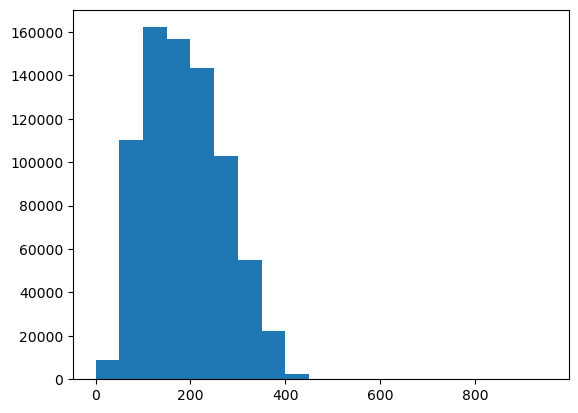

In [356]:
plt.hist(df.coast_dist_km,bins=np.arange(0,1000,50));


In [357]:
alphas1=[]
sigmas1=[]
for dist in np.arange(0,550,50):
    df_temp1=df[(df.edge_dist_km>dist)&(df.edge_dist_km<=(dist+50))]
    data1=df_temp1.area_km
    if len(data>300):
        fit1 = powerlaw.Fit(data1, xmin=35)
        sigmas1= np.append(sigmas1, fit1.sigma)
        alphas1= np.append(alphas1, fit1.alpha)
        
alphas2=[]
sigmas2=[]
for dist in np.arange(0,450,50):
    df_temp2=df[(df.coast_dist_km>dist)&(df.coast_dist_km<=(dist+50))]
    data2=df_temp2.area_km
    if len(data>300):
        fit2 = powerlaw.Fit(data2, xmin=35)
        sigmas2= np.append(sigmas2, fit2.sigma)
        alphas2= np.append(alphas2, fit2.alpha)

/opt/miniconda3/envs/lif-env/lib/python3.12/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


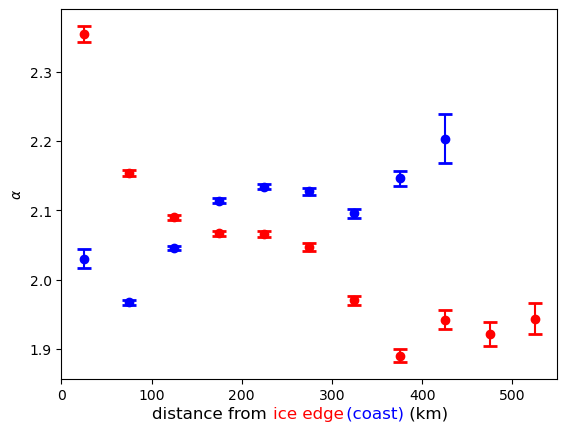

In [358]:
#plt.scatter(np.arange(0,550,50),alphas1)
plt.errorbar(np.arange(0,550,50)+25,alphas1, yerr=sigmas1,c='red', fmt='o', ecolor='red', capsize=5, capthick=2, linestyle='None', markersize=6,label=r'$\alpha$')
#plt.scatter(np.arange(0,450,50),alphas2)
plt.errorbar(np.arange(0,450,50)+25,alphas2, yerr=sigmas2,c='blue', fmt='o',  ecolor='blue', capsize=5, capthick=2, linestyle='None', markersize=6,label=r'$\alpha$')
plt.text(100, 1.8, 'distance from ', color='black', fontsize=12)
plt.text(235, 1.8, 'ice edge', color='red', fontsize=12)
plt.text(310, 1.8, ' (coast)', color='blue', fontsize=12)
plt.text(380, 1.8, ' (km) ', color='black', fontsize=12)

plt.ylabel(r'$\alpha$')
plt.savefig('/Volumes/Extreme SSD/Documents/Analysis/FSD/dist_edge_coast.png')

## separate coast and ice edge

In [266]:
from matplotlib.cm import get_cmap

In [264]:
len(np.arange(0,550,50))

11

In [343]:
# Get the Viridis colormap
cmap = get_cmap('viridis')

# Number of discrete colors you want
n_colors = len(np.arange(0,500,20))

# Create a list of discrete colors by sampling the colormap
colors = [cmap(i / n_colors) for i in range(n_colors)]

/var/folders/hb/fq6r_ywx7yn75m5mg2dr334m0000gr/T/ipykernel_89288/857289581.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


/opt/miniconda3/envs/lif-env/lib/python3.12/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


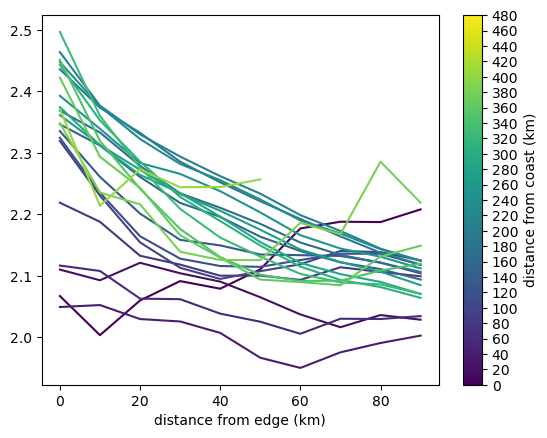

In [348]:
fig,ax=plt.subplots(1,1)
a=0
for dist_c in np.arange(0,500,20):
    alphas1=[]
    sigmas1=[]
    dists1=[]
    for dist in np.arange(0,100,10):
        df_temp1=df[(df.edge_dist_km>dist)&(df.edge_dist_km<=(dist+50))&(df.coast_dist_km>dist_c)&(df.coast_dist_km<=(dist_c+50))]
        data1=df_temp1.area_km
        if len(data1)>100:
            fit1 = powerlaw.Fit(data1, xmin=35)
            sigmas1= np.append(sigmas1, fit1.sigma)
            alphas1= np.append(alphas1, fit1.alpha)
            dists1= np.append(dists1,dist)
            #plt.errorbar(dist_c,fit1.alpha, yerr=fit1.sigma, c=colors[a], fmt='o', ecolor=colors[a], capsize=5, capthick=2, linestyle='None', markersize=6)
            # plt.scatter(dist_c,fit1.alpha,alpha=a)
    if any(dists1):
        plt.plot(dists1,alphas1, c=colors[a],label='dist from coast= '+str(dist_c))
    a+=1
# plt.ylim(1.5,3)
plt.xlabel('distance from edge (km)')
#plt.legend(ncols=2)
# Create the ScalarMappable for the colorbar
sm = ScalarMappable(cmap = 'viridis', norm=Normalize(vmin=0, vmax=len(np.arange(0,500,20)) - 1))
sm.set_array([])  # Needed for ScalarMappable but not used for this type of plot

# Add the colorbar
cbar = plt.colorbar(sm, ticks=range(n_colors),ax=ax)
cbar.set_label('distance from coast (km)')
cbar.set_ticklabels([str(b) for b in np.arange(0,500,20)])

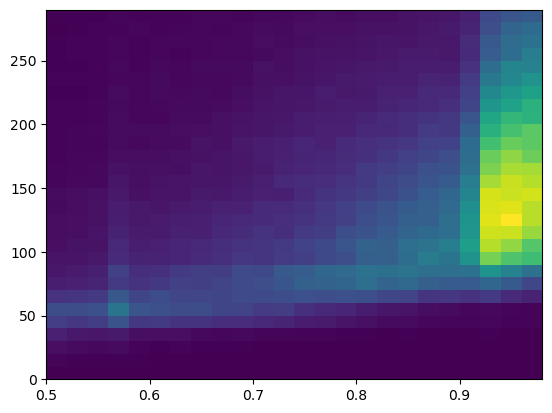

In [354]:
plt.hist2d(df.nsidc_sic,df.edge_dist_km,bins=(np.arange(.5,1,.02),np.arange(0,300,10)));

## compare coast dist

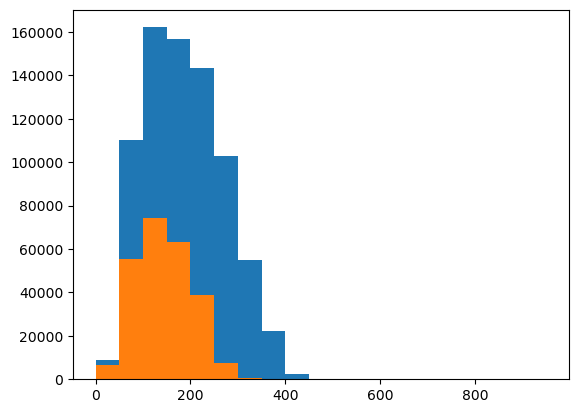

In [200]:
plt.hist(df.coast_dist_km,bins=np.arange(0,1000,50));
plt.hist(df[df.edge_dist_km>200].coast_dist_km,bins=np.arange(0,1000,50));

In [206]:
df_lt85=df[(df.coast_dist_km<=140)&(df.edge_dist_km>200)]
df_gt85=df[(df.coast_dist_km>140)&(df.edge_dist_km>200)]
cond1=r'Distance from coast $\leq$ 140 km'
cond2=r'Distance from coast > 140 km'

In [207]:
doys_lt=[]
doys_gt=[]
alphas_lt=[]
alphas_gt=[]

for d in np.arange(91,258):
    df_lt_temp=df_lt85[df_lt85.doy==d]
    df_gt_temp=df_gt85[df_gt85.doy==d]
    if len(df_lt_temp)>300:
        data=df_lt_temp.area_km
        fit = powerlaw.Fit(data, xmin=35)
        alphas_lt=np.append(alphas_lt,fit.power_law.alpha)
        doys_lt=np.append(doys_lt,d)
    if len(df_gt_temp)>300:
        data=df_gt_temp.area_km
        fit = powerlaw.Fit(data, xmin=35)
        alphas_gt=np.append(alphas_gt,fit.power_law.alpha)
        doys_gt=np.append(doys_gt,d)

/opt/miniconda3/envs/lif-env/lib/python3.12/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


In [208]:
doys_lt_s=[]
doys_gt_s=[]
alphas_lt_s=[]
alphas_gt_s=[]
sigs_gt=[]
sigs_lt=[]

for d in np.arange(91,258):
    df_lt_temp=df_lt85[(df_lt85.doy>(d-2))&(df_lt85.doy<(d+2))]
    df_gt_temp=df_gt85[(df_gt85.doy>(d-2))&(df_gt85.doy<(d+2))]
    if len(df_lt_temp)>300:
        data=df_lt_temp.area_km
        fit = powerlaw.Fit(data, xmin=35)
        alphas_lt_s=np.append(alphas_lt_s,fit.power_law.alpha)
        sigs_lt=np.append(sigs_lt,fit.power_law.sigma)
        doys_lt_s=np.append(doys_lt_s,d)
    if len(df_gt_temp)>300:
        data=df_gt_temp.area_km
        fit = powerlaw.Fit(data, xmin=35)
        alphas_gt_s=np.append(alphas_gt_s,fit.power_law.alpha)
        sigs_gt=np.append(sigs_gt,fit.power_law.sigma)
        doys_gt_s=np.append(doys_gt_s,d)

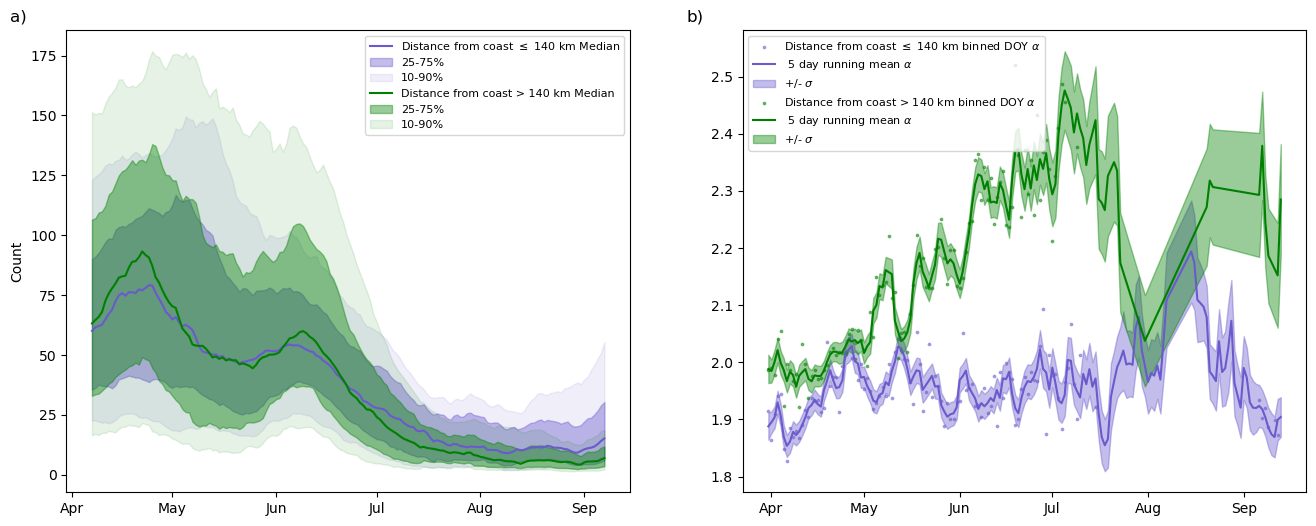

In [209]:
count_range_lt85 = df_lt85.groupby(['year', 'doy']).count().pivot_table(index='year', columns='doy', values='datetime').quantile([0.1, 0.25, 0.5, 0.75, 0.9], axis=0)
smoothed_count_range_lt85 = count_range_lt85.T.rolling(15, center=True).mean()

count_range_gt85 = df_gt85.groupby(['year', 'doy']).count().pivot_table(index='year', columns='doy', values='datetime').quantile([0.1, 0.25, 0.5, 0.75, 0.9], axis=0)
smoothed_count_range_gt85 = count_range_gt85.T.rolling(15, center=True).mean()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,6))

ax[0].plot(smoothed_count_range_lt85.index,smoothed_count_range_lt85[0.5],color='slateblue',label=cond1+r' Median')
ax[0].fill_between(smoothed_count_range_lt85.index,smoothed_count_range_lt85[0.25],smoothed_count_range_lt85[0.75],color= 'slateblue',alpha=0.4,label=r'25-75%')
ax[0].fill_between(smoothed_count_range_lt85.index,smoothed_count_range_lt85[0.1],smoothed_count_range_lt85[0.9],color='slateblue',alpha=0.1,label=r'10-90%')

ax[0].plot(smoothed_count_range_gt85.index,smoothed_count_range_gt85[0.5],color='green',label=cond2+' Median')
ax[0].fill_between(smoothed_count_range_gt85.index,smoothed_count_range_gt85[0.25],smoothed_count_range_gt85[0.75],color='green',alpha=0.4,label='25-75%')
ax[0].fill_between(smoothed_count_range_gt85.index,smoothed_count_range_gt85[0.1],smoothed_count_range_gt85[0.9],color='green',alpha=0.1,label='10-90%')


dr = pd.date_range('2020-04-01', '2020-09-01', freq='1MS')
ax[0].set_xticks(dr.dayofyear, [d.strftime('%b') for d in dr]);
ax[0].set_ylabel('Count')

ax[0].legend( fontsize=8)
ax[0].set_title('a)', loc='left', x=-.1)

ax[1].scatter(doys_lt,alphas_lt,color='slateblue',s=3,alpha=0.5,label=cond1+r' binned DOY $\alpha$' )
ax[1].plot(doys_lt_s,alphas_lt_s,color='slateblue',label= r' 5 day running mean $\alpha$')
ax[1].fill_between(doys_lt_s,alphas_lt_s-sigs_lt,alphas_lt_s+sigs_lt,color='slateblue',alpha=0.4,label=r'+/- $\sigma$')

ax[1].scatter(doys_gt,alphas_gt,color='green',s=3,alpha=0.5,label=cond2+r' binned DOY $\alpha$')
ax[1].plot(doys_gt_s,alphas_gt_s,color='green',label=r' 5 day running mean $\alpha$')
ax[1].fill_between(doys_gt_s,alphas_gt_s-sigs_gt,alphas_gt_s+sigs_gt,color='green',alpha=0.4,label=r'+/- $\sigma$')

dr = pd.date_range('2020-04-01', '2020-09-01', freq='1MS')
ax[1].set_xticks(dr.dayofyear, [d.strftime('%b') for d in dr]);
ax[1].legend( fontsize=8)
ax[1].set_title('b)', loc='left', x=-.1)
# 
# ax.legend(h, ['Median', '25-75%', '10-90%'], ncols=1, loc='ur')
# ax.format(ylabel='Count', xlabel='', title='Number of floes per image')
plt.savefig('/Volumes/Extreme SSD/Documents/Analysis/FSD/annals_fig_coast_dist.png')